## For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

        
### In the exercises below you'll be asked to do the following:
### Perform standard imports, load & plot the dataset (code provided)
### Prepare data for an LSTM model
### Define the LSTM model, loss and optimization functions
### Train the model
### Evaluate the model on test data

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('../Data/TimeSeriesData/Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

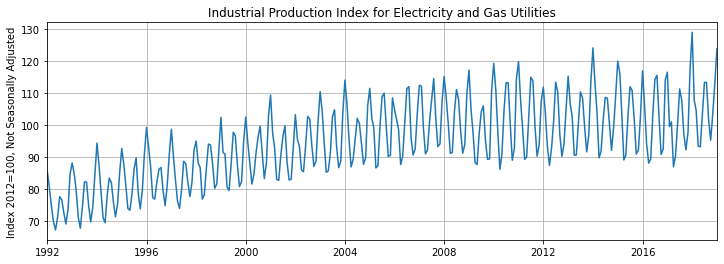

In [2]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

In [5]:
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 85.556
First item, scaled: [-0.4091274]


In [8]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [9]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 301


In [10]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]
    
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
epochs = 50

for i in range(epochs):
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'{i+1} of {epochs} epochs completed')

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

In [15]:
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
preds[window_size:]

[0.42185112833976746,
 0.2170511782169342,
 -0.2843514680862427,
 -0.2051706314086914,
 0.25567007064819336,
 0.3802016079425812,
 0.13380901515483856,
 -0.06449156254529953,
 -0.31384068727493286,
 -0.13372927904129028,
 0.21123453974723816,
 0.6386828422546387]

In [16]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[111.12063904],
       [104.82007097],
       [ 89.39466926],
       [ 91.83062811],
       [106.00816189],
       [109.83931237],
       [102.25916745],
       [ 96.15854932],
       [ 88.48744818],
       [ 94.02848559],
       [104.641125  ],
       [117.7913583 ]])